In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from scene_synthesis.datasets.nuScenes import NuScenesDataset
from scene_synthesis.datasets.utils import collate_train
from scene_synthesis.networks.feature_extractors import ResNet18
from scene_synthesis.networks.autoregressive_transformer import AutoregressiveTransformer

def to_numpy(data: dict):
    for k in data:
        if isinstance(data[k], torch.Tensor):
            data[k] = data[k].squeeze()
            if not data[k].shape:
                data[k] = data[k].item()
            else:
                data[k] = data[k].numpy()
        elif isinstance(data[k], dict):
            to_numpy(data[k])


In [2]:
plt.ion()
np.random.seed(0)
torch.manual_seed(0)
dataset = NuScenesDataset("/media/yifanlin/My Passport/data/nuScene-processed", train=True)
axes_limit = 40
cat2color = {1: 'red', 2: 'blue', 3: 'green'}
feature_extractor = ResNet18(4, 512)
model = AutoregressiveTransformer(feature_extractor)
model.load_state_dict(torch.load('./ckpts/best'))


<All keys matched successfully>

In [3]:
plt.ion()
# np.random.seed(0)
# torch.manual_seed(0)
dataset = NuScenesDataset("/media/yifanlin/My Passport/data/nuScene-processed", train=True)
axes_limit = 40
cat2color = {1: 'red', 2: 'blue', 3: 'green'}
feature_extractor = ResNet18(4, 512)
model = AutoregressiveTransformer(feature_extractor)
model.load_state_dict(torch.load('./ckpts/best'))


In [57]:
condition = {
    "category": 1,  # int
    "location": None,  # (1, 2)
    "bbox": None,  # (1, 2), (1, 1)
    "velocity": None  # (1, 1), (1, 1), (1, 1)
}


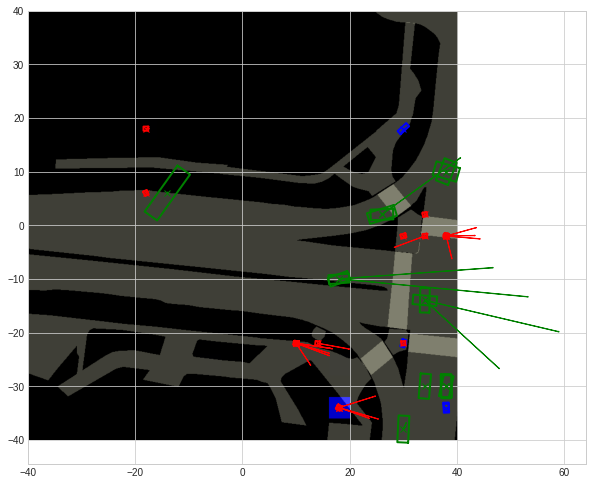

In [60]:
condition = {
    "category": 3,  # int
    "location": None,  # (1, 2)
    "bbox": None,  # (1, 2), (1, 1)
    "velocity": None  # (1, 1), (1, 1), (1, 1)
}


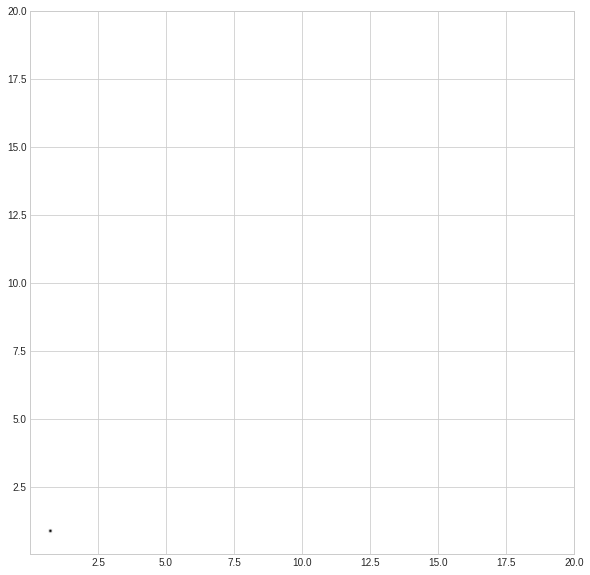

In [50]:
preds, probs = model.generate(input_data, length, condition)
to_numpy(preds)
category = preds['category']
if category != 0:
    preds['location'] = np.array([preds['location'] // 20, preds['location'] % 20]) * 4 - 40 + 2
    data['category'] = np.concatenate([data['category'], np.array([preds['category']])], axis=0)
    data['location'] = np.concatenate([data['location'], preds['location'].reshape(1, -1)], axis=0)
    data['bbox'] = np.concatenate([data['bbox'], np.concatenate([preds['bbox']['wl'], np.array([preds['bbox']['theta']])], axis=0).reshape(1, -1)], axis=0)
    data['velocity'] = np.concatenate([data['velocity'], np.array([[preds['velocity']['s'] * preds['velocity']['moving'], preds['velocity']['omega']]])], axis=0)
    input_data = {}
    input_data['category'] = torch.tensor(data['category'])
    for k in ['location', 'bbox', 'velocity', 'map']:
        input_data[k] = torch.tensor(data[k], dtype=torch.float)
    input_data, length, _ = collate_train([input_data], keep_all=True)

_, ax = plt.subplots(figsize=(10, 10))
map_layers = data['map'].sum(axis=0)
map_layers /= map_layers.max() * 2
map_layers = np.stack([map_layers] * 3, axis=-1)
grid = np.meshgrid(np.arange(-axes_limit, axes_limit, 4), np.flip(np.arange(-axes_limit, axes_limit, 4)))
grid = np.stack(grid, axis=-1)
grid = (grid + 40) // 4
grid = grid[..., 0] * 20 + grid[..., 1]
prob_map = np.exp(probs['location'].log_prob(torch.tensor(grid)).numpy())
prob_map /= prob_map.sum()
prob_map = np.kron(prob_map, np.ones((40, 40)))
map_layers[..., 2] += prob_map
map_layers[..., 2] /= map_layers[..., 2].max()
ax.imshow(map_layers, extent=[-axes_limit, axes_limit, -axes_limit, axes_limit])
for i in range(length.item()):
    if data['category'][i] != 0:
        color = cat2color[data['category'][i]]
        loc = data['location'][i]
        ax.plot(loc[0], loc[1], 'x', color=color)
        w, l, theta = data['bbox'][i]
        corners = np.array([[l / 2, w / 2],
                            [-l / 2, w / 2],
                            [-l / 2, -w / 2],
                            [l / 2, -w / 2],
                            [l / 2, w / 2]])
        rotation = np.array([[np.cos(theta), np.sin(theta)],
                             [-np.sin(theta), np.cos(theta)]])
        corners = np.dot(corners, rotation) + loc
        ax.plot(corners[:, 0], corners[:, 1], color=color, linewidth=2)
        speed, omega = data['velocity'][i]
        rotation = np.array([[np.cos(omega), np.sin(omega)],
                             [-np.sin(omega), np.cos(omega)]])
        velocity = np.dot(np.array([speed, 0]), rotation)
        ax.arrow(loc[0], loc[1], velocity[0] * 5, velocity[1] * 5, color=color, width=0.05)


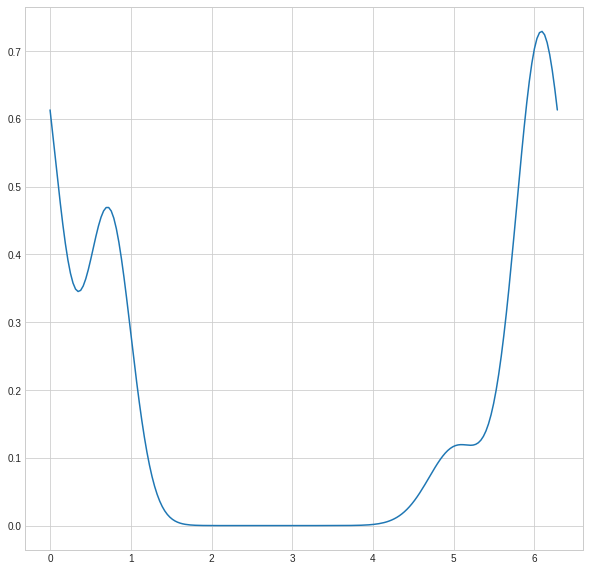

In [39]:
probs['bbox']['theta'].component_distribution.mean

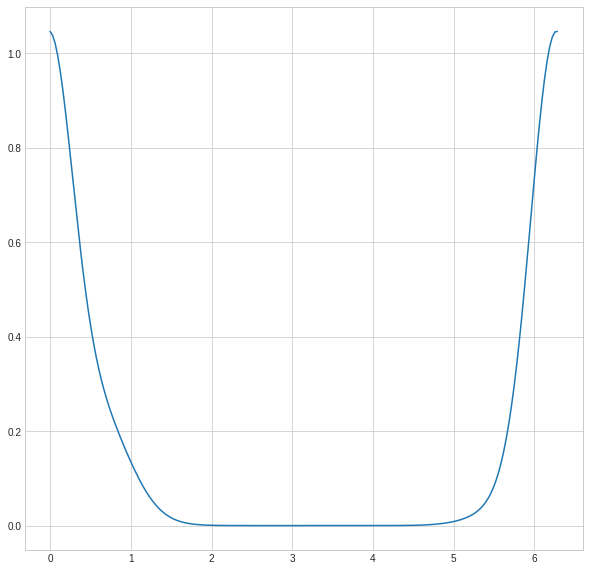

In [74]:
grid = np.linspace(0, 2 * np.pi, 200)[..., None]
prob_map = np.exp(probs['bbox']['theta'].log_prob(torch.tensor(grid)).numpy())
plt.figure(figsize=(10, 10))
plt.plot(grid, prob_map)

In [17]:
preds['bbox']['theta'] / np.pi * 180

-43.41117972298364

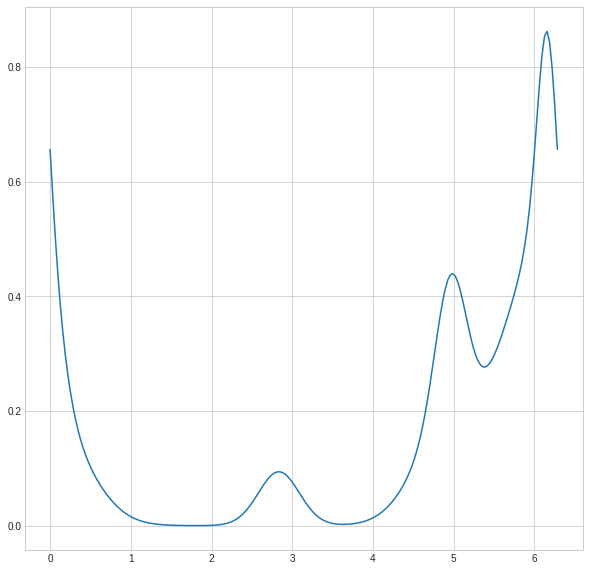

In [32]:
grid = np.linspace(0, 2 * np.pi, 200)[..., None]
prob_map = np.exp(probs['velocity']['omega'].log_prob(torch.tensor(grid)).numpy())
plt.figure(figsize=(10, 10))
plt.plot(grid, prob_map)

In [ ]:
preds['velocity']['omega'] / np.pi * 180